In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split,KFold

In [2]:
train = pd.read_csv('../input/dataset2147b1d/train_file.csv')
test = pd.read_csv('../input/dataset2147b1d/test_file.csv')

In [3]:
columns = ['Subtopic','Greater_Risk_Question','Description','Sex','Race','Grade','QuestionCode','StratID1','StratID2','StratID3','StratificationType','YEAR','LocationDesc']
for col in columns:
    rev = lambda x : {v:k for k,v in x.items()}
    index = rev(dict(enumerate(list(train[col].value_counts().keys()))))
    train[col] = train[col].apply(lambda x : index[x])
    test[col] = test[col].apply(lambda x : index[x])

In [4]:
X = train[['Subtopic','Description','Sex','Race','Grade','StratID1','StratID2','StratID3','StratificationType','Sample_Size','YEAR','LocationDesc']]
Y = train['Greater_Risk_Probability']
x_test = test[['Subtopic','Description','Sex','Race','Grade','StratID1','StratID2','StratID3','StratificationType','Sample_Size','YEAR','LocationDesc']]

In [5]:
lgb_params = {
    "objective" : "regression",
    "metric" : "rmse",
    "boosting": 'gbdt',
    "max_depth" : -1,
    "num_leaves" : 13,
    "learning_rate" : 0.1,
    "min_data_in_leaf": 0,
    "bagging_seed" : 1234,
    "verbosity" : 1,
    "lambda_l2" : 5.0,
    "seed": 1234,
    "drop_rate" : 0.5,
    "min_data_per_group":1,
    "max_bin" : 10,
}

In [6]:
kf = KFold(n_splits=15,shuffle=True,random_state=31)

all_preds = []

for t,v in kf.split(X,Y):
    x_train,x_valid,y_train,y_valid = X.iloc[t],X.iloc[v],Y.iloc[t],Y.iloc[v]
    lgb_train = lgb.Dataset(x_train,
                            label=y_train,
                            categorical_feature=['Subtopic','Description','Sex','Race','Grade','StratID1','StratID2','StratID3','StratificationType','YEAR','LocationDesc'])
    lgb_valid = lgb.Dataset(x_valid,
                            label=y_valid, 
                            categorical_feature=['Subtopic','Description','Sex','Race','Grade','StratID1','StratID2','StratID3','StratificationType','YEAR','LocationDesc'])
    evals_result = {}
    lgb_clf = lgb.train(lgb_params,
                    lgb_train,
                    100000,
                    valid_sets = [lgb_train,lgb_valid],
                    early_stopping_rounds=3000,
                    verbose_eval = 1000,
                    evals_result=evals_result
                   )
    all_preds.append(lgb_clf.predict(x_test))

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 3000 rounds.
[1000]	training's rmse: 3.41899	valid_1's rmse: 4.33927
[2000]	training's rmse: 2.91249	valid_1's rmse: 4.19607
[3000]	training's rmse: 2.58532	valid_1's rmse: 4.13735
[4000]	training's rmse: 2.33052	valid_1's rmse: 4.10213
[5000]	training's rmse: 2.13077	valid_1's rmse: 4.08418
[6000]	training's rmse: 1.95725	valid_1's rmse: 4.06864
[7000]	training's rmse: 1.80928	valid_1's rmse: 4.06024
[8000]	training's rmse: 1.68172	valid_1's rmse: 4.05364
[9000]	training's rmse: 1.56988	valid_1's rmse: 4.04633
[10000]	training's rmse: 1.46785	valid_1's rmse: 4.0456
[11000]	training's rmse: 1.37698	valid_1's rmse: 4.04159
[12000]	training's rmse: 1.29406	valid_1's rmse: 4.04174
[13000]	training's rmse: 1.21893	valid_1's rmse: 4.03997
[14000]	training's rmse: 1.14994	valid_1's rmse: 4.03836
[15000]	training's rmse: 1.08695	valid_1's rmse: 4.0396
[16000]	training's rmse: 1.03019	valid_1's rmse: 4.04063
[17000]	training's rmse: 0.976939	v

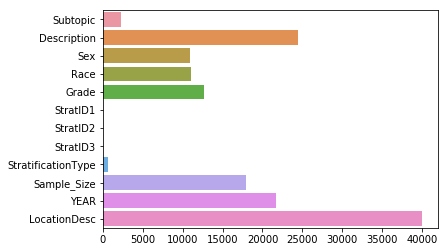

In [7]:
import seaborn as sns
imp = lgb_clf.feature_importance()
fet = lgb_clf.feature_name()
sns.barplot(x=imp, y=fet)

In [8]:
all_preds = np.vstack(all_preds)

In [9]:
preds = np.mean(all_preds,axis=0)

In [10]:
preds.shape

(36932,)

In [11]:
submission = pd.DataFrame()
submission['Patient_ID'] = test['Patient_ID']
submission['Greater_Risk_Probability'] = preds
submission

,Patient_ID,Greater_Risk_Probability
0,55400,59.826614
1,55401,29.004116
2,55402,55.252582
3,55403,18.244876
4,55404,5.883608
5,55405,48.089758
6,55406,8.856620
7,55407,5.165112
8,55408,18.210373
9,55409,8.622976


In [12]:
submission.to_csv('submission.csv',index=False)